In [32]:
import numpy as np
import pandas as pd
from scipy.stats import iqr
import matplotlib.pyplot as plt
import seaborn as sns
from systole import import_ppg
from systole.detection import oxi_peaks, missed_beat, artifact_removal, hrv_subspaces
from systole.hrv import rmssd

Here, we describe the default method used to detect and remove artifacts and outliers in RR time series. This section presuppose that the signal analized is good enought to allow a number of correct peak detection allowing artefact detection and correction. See the **Signal quality** section for more details.

In [7]:
# Load data
oxi = import_ppg('1')[0, :]

# Extract peak vectors
signal, peaks = oxi_peaks(oxi)

# Artefact detection and correction

In [4]:
# Artefact correction
clean_peaks, per = artifact_removal(peaks)

# The 3 most common types of artefacts

Three most common artefact types in HRV time series are:
1. **Extra beat**
2. **Missed beat**
3. **Ectopic beat**

## Missed beats

Missed beats are corrected by adding new  occurrence time so that it divides the detected long RR interval into two equal halves and RR interval series is then recalculated (see Lipponen & Tarvainen, 2019).

In [16]:
missed_peaks = peaks.copy()

# Remove 1 peak
missed_peaks[np.where(missed_peaks)[0][100]] = 0

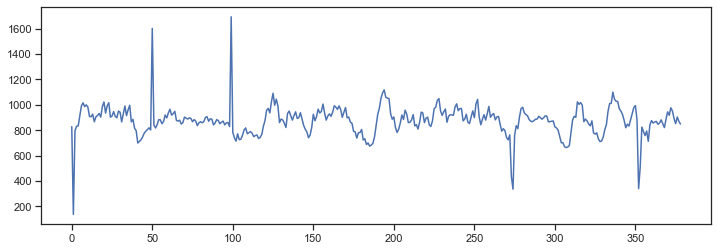

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(np.diff(np.where(missed_peaks)[0]), 'b-')

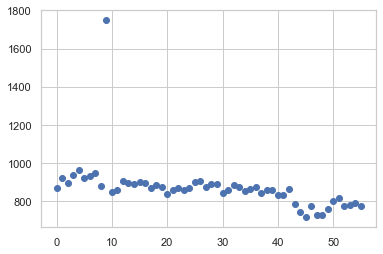

In [223]:
# Add peak
idx = np.where(peaks)[0][10]
peaks[idx] = 0
plt.plot(np.diff(np.where(peaks)[0]), 'bo')

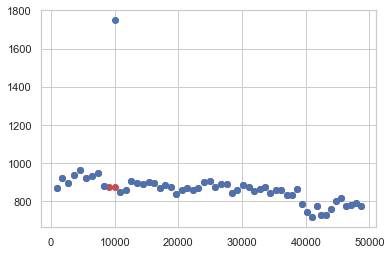

In [224]:
idx = np.argmax(np.diff(np.where(peaks)[0]) > 1200)
new_peaks, per = missed_beat(peaks, idx)

plt.plot(np.cumsum(np.diff(np.where(new_peaks)[0])),
         np.diff(np.where(new_peaks)[0]), 'ro')

plt.plot(np.cumsum(np.diff(np.where(peaks)[0])),
         np.diff(np.where(peaks)[0]), 'bo')

Here, we will assuma that one peaks is missing, and will thus remove the outlier R-R interval and interpolate 2 new values.

## Extra beats

In [ ]:
extra_peaks = peaks.copy()

# Add 1 extra peak
extra_peaks[np.where(extra_peaks==0)[0][100]] = 1

Ths can easily be corrected by removing the first outlier and recomputing the RR time series. This procedure can be repeated until no outlier is found.

In [300]:
while np.any(np.diff(np.where(peaks)[0]) < 600):
    # Find outliers using threshold
    idx = np.where(np.diff(np.where(peaks)[0]) < 600)[0]
    peaks[np.where(peaks)[0][idx[0]+1]] = 0

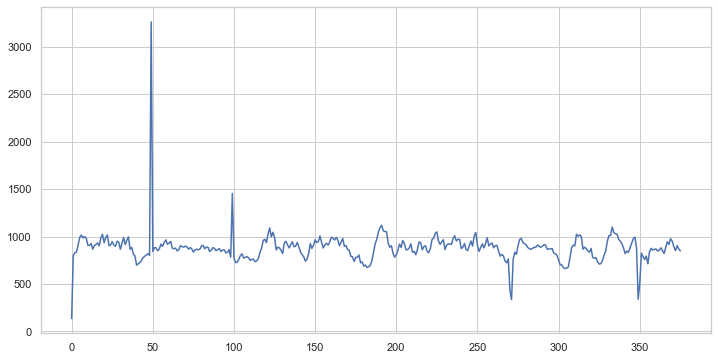

In [182]:
plt.figure(figsize=(12, 6))
plt.plot(np.diff(np.where(peaks)[0]), 'b-')

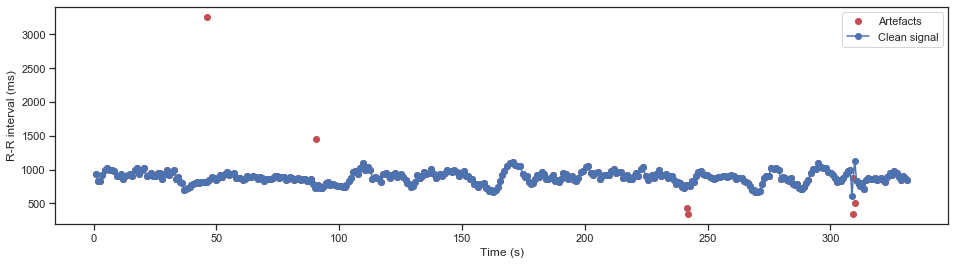

In [5]:
plt.figure(figsize=(16, 4))
plt.plot(np.cumsum(np.diff(np.where(peaks)[0]))/1000,
         np.diff(np.where(peaks)[0]), 'ro', label='Artefacts')  # Artefacts
plt.plot(np.cumsum(np.diff(np.where(clean_peaks)[0]))/1000,
         np.diff(np.where(clean_peaks)[0]), 'bo-', label='Clean signal')  # Cleaned peaks
plt.ylabel('R-R interval (ms)')
plt.xlabel('Time (s)')
plt.legend()

# Estimation of artefacts correction errors

A simple artefact in the RR time serie can cause major change in the estimation of HRV metrics. As the correction of detected artefacts involve the interpolation of unknown values, small differences can still be found event after this procedure. It is possible to estimate the amout of error induced by the correction algorithm by comparing metrics before and after artefact correction (see Rincon et al. 2018).

In [47]:
rms = []
for i in range(100):
    noisy_peaks = peaks.copy()
    
    # Add extra beats (n=5)
    idx = np.random.choice(np.where(noisy_peaks==0)[0], size=5)
    noisy_peaks[idx] = 1
    
    # Apply artifact correction
    clean_peaks, per = artifact_removal(noisy_peaks)
    stats = time_domain(np.diff(np.where(clean_peaks)[0]))
    rms.append(stats.Values[stats.Metric=='RMSSD'].iloc[0])

In [76]:
from scipy import interpolate
rr = np.diff(np.where(clean_peaks)[0])
time = np.arange(0, len(rr))

# Remove value
rr_mising = np.delete(rr, 50)
time_missing = np.delete(time, 50)

f = interpolate.interp1d(time_missing, rr_mising, kind='cubic')
new_rr = f(time)

(25, 75)

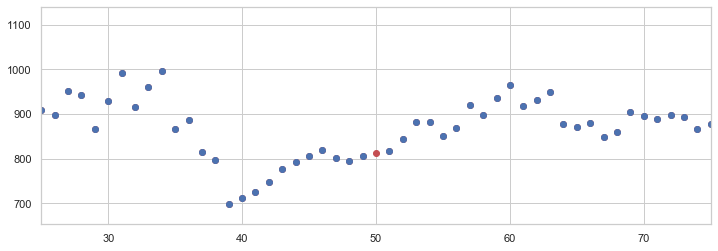

In [77]:
plt.figure(figsize=(12, 4))
plt.plot(time, new_rr, 'ro')
plt.plot(time_missing, rr_mising, 'bo')
plt.xlim(25, 75)

## Ectopic beats

The difference between two successive RR intervals can be used to detect ectopic and misaligned beats. Following Lipponen and Tarvainen (2019), we can also represent the RR time series according two dimensions. Long beats (including missed beat detections) form positive negative (PN), short beats form negative positive (NP), and extra beats form NNP or NPP segments to the dRR series. Because pulse oximeter measure oxigen in arterial blood, it is less likely to have ectopic artefacts. However, signal noise and movements can cause deviation that will present similar patterns during the analysis. The same algorithm can therefor be applied to correct shiffted beats.

The *dRR* time serie is defined as the first derivative of the RR interval time serie. The first value is set to 0 to ensure the vectors have equal lengths:

<center>
$
\begin{align*}
dRR_{j} = \begin{cases}
 & RR_{j}-RR_{j-1} & \text{ if } j\geqslant 2 \\ 
 & 0 & \text{ if } j= 1
\end{cases}
\end{align*}
$ , where $RR$ is the RR time serie of length $N$.
</center>

This series is then normalized using a threshold $Th$ to ensure adaptation to different HRV levels. 

$$dRR_{j}= \frac{dRR_{j}}{Th_{j}}, j=1...N$$

$Th$ is defined as a times quartile deviation (QD) of the absolute values of the 91 surrounding beat interval differences.

<center>
$TH_{j}=\alpha QD\left [ \left | dRR_{j-45... j+45} \right | \right ], j=1...N$, where $\alpha = 5.2$.
</center>

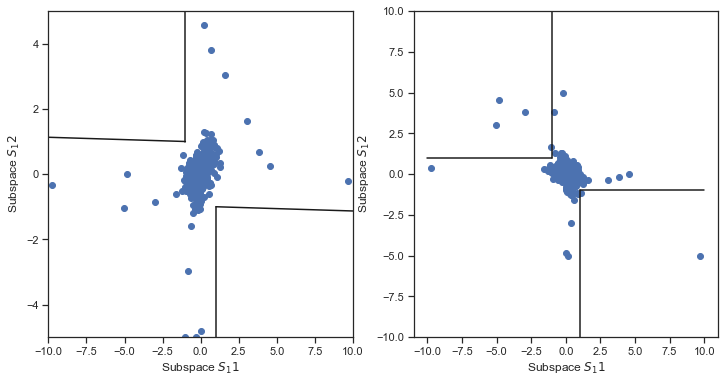

In [109]:
sp1, sp2, sp3 = hrv_subspaces(np.diff(np.where(peaks)[0]))
plot_subspaces(sp1, sp2, sp3)

In [65]:
def plot_subspaces(x, subspace2=None, subspace3=None, c1=0.13, c2=0.17, xlim=10, ylim=5):
    """Plot hrv subspace as described by Lipponen & Tarvainen (2019).
    
    Parameters
    ----------
    x : array
        Array of RR intervals or subspace1. If subspace1 is provided, subspace2 and 3 must also be provided.
    subspace2, subspace3 : array | None
        Default is `None` (expect x to be RR time serie).
    c1 : float
        Fixed variable controling the slope of the threshold lines. Default set to 0.13.
    c2 : float
        Fixed variable controling the slope of the threshold lines. Default set to 0.17.

    Return
    ------
    ax : Matplotlib.Axes
        The figure.
    
    References
    ----------
    [1] Lipponen, J. A., & Tarvainen, M. P. (2019). A robust algorithm for heart rate variability time
        series artefact correction using novel beat classification. Journal of Medical Engineering &
        Technology, 43(3), 173–181. https://doi.org/10.1080/03091902.2019.1640306
    """
    if (subspace3 is not None) & (subspace3 is not None):
        subspace1 = x
    else:
        assert isinstance(x, (np.ndarray, np.generic))
        subspace1, subspace2, subspace3 = hrv_subspaces(x)
    
    # Rescale to show outlier in scatterplot
    if xlim is not None:
        subspace1[subspace1<-xlim] = -xlim
        subspace1[subspace1>xlim] = xlim
    if ylim is not None:
        subspace2[subspace2<-ylim] = -ylim
        subspace2[subspace2>ylim] = ylim
        
        subspace3[subspace3<-ylim] = -ylim
        subspace3[subspace3>ylim] = ylim
        
    plt.figure(figsize=(12, 6))
    plt.title('Subspace of successive RR interval differences')
    plt.subplot(121)
    plt.plot(subspace1, subspace2, 'bo')

    # Upper area
    plt.plot([-1, -10], [1, -c1*-10 -c2], 'k')
    plt.plot([-1, -1], [1, 10], 'k')

    # Lower area
    plt.plot([1, 10], [-1, -c1*10 +c2], 'k')
    plt.plot([1, 1], [-1, -10], 'k')

    plt.xlabel('Subspace $S_11$')
    plt.ylabel('Subspace $S_12$')
    plt.ylim(-5, 5)
    plt.xlim(-10, 10)

    plt.subplot(122)
    plt.plot(subspace1, subspace3, 'bo')

    # Upper area
    plt.plot([-1, -10], [1, 1], 'k')
    plt.plot([-1, -1], [1, 10], 'k')

    # Lower area
    plt.plot([1, 10], [-1, -1], 'k')
    plt.plot([1, 1], [-1, -10], 'k')

    plt.xlabel('Subspace $S_11$')
    plt.ylabel('Subspace $S_12$')
    plt.ylim(-5, 5)
    plt.ylim(-10, 10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


ValueError: x and y must have same first dimension, but have shapes (375,) and (0,)

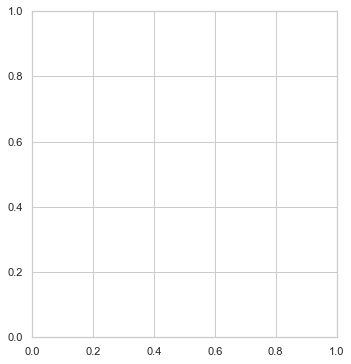

In [200]:
plot_subspaces(np.where(peaks)[0])

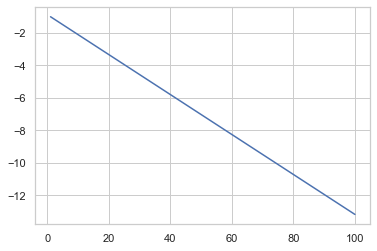

In [145]:
x = np.linspace(1, 2000, 100)
plt.plot([1, 100], [-1, -c1*100 -c2])

# References

Rincon Soler, A. I., Silva, L. E. V., Fazan, R., Jr., & Murta, L. O., Jr. (2018). The impact of artifact correction methods of RR series on heart rate variability parameters. Journal of Applied Physiology, 124(3), 646–652. https://doi.org/10.1152/japplphysiol.00927.2016

Al Osman, H., Eid, M., & El Saddik, A. (2015). A Pattern-Based Windowed Impulse Rejection Filter for Nonpathological HRV Artifacts Correction. IEEE Transactions on Instrumentation and Measurement, 64(7), 1944–1957. https://doi.org/10.1109/tim.2014.2370496

Lippman, N., Stein, K. M., & Lerman, B. B. (1994). Comparison of methods for removal of ectopy in measurement of heart rate variability. The American Journal of Physiology, 267, H411–H418.

Morelli, D., Rossi, A., Cairo, M., & Clifton, D. A. (2019). Analysis of the Impact of Interpolation Methods of Missing RR-intervals Caused by Motion Artifacts on HRV Features Estimations. Sensors, 19(14), 3163. https://doi.org/10.3390/s19143163

Lipponen, J. A., & Tarvainen, M. P. (2019). A robust algorithm for heart rate variability time series artefact correction using novel beat classification. Journal of Medical Engineering & Technology, 43(3), 173–181. https://doi.org/10.1080/03091902.2019.1640306
